In [1]:
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import glob
import os
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
import numpy as np

In [2]:
# Inputs

# Start and end time period to analyse smart meter data
start_date = datetime.strptime('01-01-2015 00:00:00', '%d-%m-%Y %H:%M:%S')
end_date = datetime.strptime('01-01-2017  00:00:00', '%d-%m-%Y %H:%M:%S')

# Water usaage of an individual property that exceeds (threshold x average usge within a DMA) is considered High usage/CSl
threshold = 1.5

datetime.datetime(2017, 1, 1, 0, 0)

### Get building data

In [3]:
# Read building data
path = r'C:/Users/alkaye/OneDrive - Capgemini/04 Internal Work/02 Working Groups/Geospatial/Smart Meter Demonstrator/'

# This was prepared in qgis to map buildings to postcode districts
building_gdf = gpd.read_file(path+'leeds_buildings.geojson')

In [4]:
num_buildings = len(building_gdf)
print(num_buildings)

996


In [5]:
building_gdf = building_gdf[['district', 'geometry']]

In [6]:
building_gdf['area'] = building_gdf['geometry'].area*10**8
building_gdf['area'] = building_gdf['area'].round(8)

C:\Users\alkaye\AppData\Local\Temp\ipykernel_14992\2397522797.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  building_gdf['area'] = building_gdf['geometry'].area*10**8


In [7]:
building_gdf = (building_gdf
                .sort_values('area')
                .drop_duplicates('area')
               ).reset_index(drop=True)

In [8]:
building_gdf

,district,geometry,area
0,LS2,"POLYGON Z ((-1.54518 53.80417 0.00000, -1.5451...",0.286860
1,LS2,"POLYGON Z ((-1.55586 53.80439 0.00000, -1.5558...",0.287432
2,LS1,"POLYGON Z ((-1.55239 53.79395 0.00000, -1.5522...",0.290083
3,LS2,"POLYGON Z ((-1.55410 53.80722 0.00000, -1.5538...",0.294897
4,LS1,"POLYGON Z ((-1.55808 53.79904 0.00000, -1.5580...",0.296198
...,...,...,...
934,LS2,"POLYGON Z ((-1.55474 53.80839 0.00000, -1.5549...",258.365299
935,LS2,"POLYGON Z ((-1.54397 53.80247 0.00000, -1.5439...",320.399964
936,LS1,"POLYGON Z ((-1.54381 53.79716 0.00000, -1.5444...",455.792208
937,LS1,"POLYGON Z ((-1.54740 53.79397 0.00000, -1.5474...",493.630262


### Get district data

In [9]:
# Read Outcode Boundary data
# buildings data taken from OS
geo_path = r'C:/Users/alkaye/OneDrive - Capgemini/04 Internal Work/02 Working Groups/Geospatial/Smart Meter Demonstrator/gb-postcodes-v5/gb-postcodes-v5/districts/'

district_list = ['LS1', 'LS2', 'LS3']

district_gdf = gpd.GeoDataFrame()

for outcode in district_list:
    boundary = gpd.read_file(geo_path + outcode + ".geojson")
    district_gdf = pd.concat([district_gdf, boundary])

In [10]:
district_gdf

,district,mapit_code,geometry
0,LS1,LS1,"MULTIPOLYGON (((-1.53825 53.79582, -1.53818 53..."
0,LS2,LS2,"MULTIPOLYGON (((-1.54028 53.80489, -1.54027 53..."
0,LS3,LS3,"MULTIPOLYGON (((-1.56438 53.79644, -1.56437 53..."


In [11]:
#district_gdf.to_file('for_powerbi/districts.geojson', driver='GeoJSON')

### Get household data

In [12]:
# Read household address data
# data provided by Alex Kirby, extracted from EPC household level data
path = r'C:/Users/alkaye/OneDrive - Capgemini/04 Internal Work/02 Working Groups/Geospatial/Smart Meter Demonstrator/London_houses_all_EPC_ratings/London_houses_all_EPC_ratings/'

# We are using a sample, we can improve the mapping of properties to addresses
household_df = pd.read_csv(path+'London_houses.csv', nrows=1100)

In [13]:
# filter rows
household_df = household_df[['address1', 'address2', 'postcode','total-floor-area','local-authority-label']]

# remove excess header rows
household_df = household_df[household_df['total-floor-area'] != 'total-floor-area'].reset_index(drop=True)

# only keep number of buildings required
household_df = household_df[:num_buildings]

household_df['total-floor-area'] = pd.to_numeric(household_df['total-floor-area'])

In [14]:
household_df = household_df.sort_values(['total-floor-area']).reset_index()

In [15]:
# Add a unique string index
household_df['id'] = 'Household ' + household_df['index'].astype(str)
household_df =household_df.drop(['index'], axis=1)

In [16]:
household_df = household_df[['id', 'address1', 'address2', 'postcode', 'local-authority-label', 'total-floor-area']]

In [17]:
num_households = 0.9*num_buildings

household_df['property_type'] = np.where(household_df.index <= num_households, 'resdiential', 'commercial')

household_df

,id,address1,address2,postcode,local-authority-label,total-floor-area,property_type
0,Household 553,Flat 5,"65, Ravensbourne Road",BR1 1HW,Bromley,14.0,resdiential
1,Household 554,Flat 2,"65, Ravensbourne Road",BR1 1HW,Bromley,14.0,resdiential
2,Household 909,Flat 2 Weeks House,"204-206, High Street",BR1 1PW,Bromley,23.0,resdiential
3,Household 821,Flat 2,205 High Street,BR1 1NY,Bromley,23.2,resdiential
4,Household 883,Flat 5,Harmony Apartments,BR1 1PQ,Bromley,26.0,resdiential
...,...,...,...,...,...,...,...
991,Household 483,56 RAVENSBOURNE ROAD,BROMLEY,BR1 1HP,Bromley,155.0,commercial
992,Household 799,First And Second Floors,183a High Street,BR1 1NN,Bromley,156.0,commercial
993,Household 456,25 Ravensbourne Road,NaN,BR1 1HN,Bromley,162.0,commercial
994,Household 555,"71, Ravensbourne Road",NaN,BR1 1HW,Bromley,165.0,commercial


### Prepare Water Usage Table (Hourly Level)

In [18]:
# Read water usage data
# Open data on internet. Alicante smart meter trial data
path = r'C:/Users/alkaye/OneDrive - Capgemini/04 Internal Work/02 Working Groups/Geospatial/Smart Meter Demonstrator/swm_trialA_1k_clean/'

water_df = pd.read_csv(path+'swm_trialA_1k_clean.csv', delimiter=';')

In [19]:
water_df

,user.key,datetime,meter.reading,diff
0,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,19/05/2017 23:17:50,179015.0,2
1,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,19/05/2017 22:17:50,179013.0,7
2,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,19/05/2017 21:17:50,179006.0,0
3,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,19/05/2017 20:17:50,179006.0,4
4,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,19/05/2017 19:17:50,179002.0,9
...,...,...,...,...
16855952,10692855-422d-4389-9389-83b8b3f2bdec,01/01/2015 11:10:11,181989.0,0
16855953,10692855-422d-4389-9389-83b8b3f2bdec,01/01/2015 10:10:11,181989.0,0
16855954,10692855-422d-4389-9389-83b8b3f2bdec,01/01/2015 09:10:09,181989.0,0
16855955,10692855-422d-4389-9389-83b8b3f2bdec,01/01/2015 08:10:09,181989.0,0


In [20]:
water_df['date'] = [x[:10] for x in water_df['datetime']]
water_df['hour'] = [x[11:13] for x in water_df['datetime']]

water_df['date'] = pd.to_datetime(water_df['date'], format='%d/%m/%Y')
water_df = water_df[(water_df['date'] >= start_date) & (water_df['date'] <= end_date)]
#water_df = water_df.reset_index(drop=True)

In [21]:
water_df = water_df.drop(['datetime', 'meter.reading'], axis=1)

In [22]:
unique_list = water_df['user.key'].unique().tolist()

# filter the full list to match the number of buildings we have
filtered_list = unique_list[0:num_buildings]

In [23]:
# filter rows based on filtered list values
mask = water_df['user.key'].isin(filtered_list)
water_df = water_df[mask].copy()
water_df = water_df.reset_index(drop=True)

In [24]:
water_df = water_df[['user.key', 'date', 'hour', 'diff']]

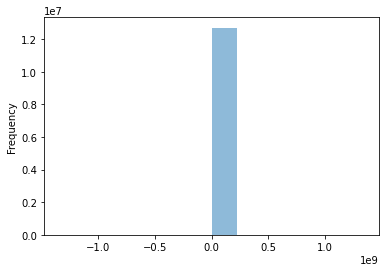

In [25]:
# There are some extremes in the data that need fixing
ax = water_df['diff'].plot.hist(bins=12, alpha=0.5)

In [26]:
water_df.loc[water_df["diff"] < 0, "diff"] = 0
water_df.loc[water_df["diff"] > 150, "diff"] = 0

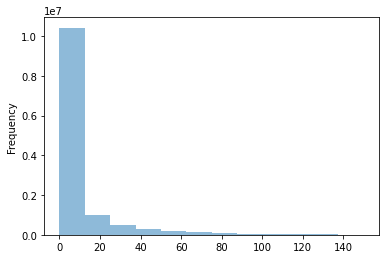

In [27]:
# There are some extremes in the data that need fixing
ax = water_df['diff'].plot.hist(bins=12, alpha=0.5)

In [28]:
water_df

,user.key,date,hour,diff
0,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,2017-01-01,23,0
1,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,2017-01-01,22,4
2,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,2017-01-01,21,9
3,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,2017-01-01,20,8
4,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,2017-01-01,19,1
...,...,...,...,...
12707287,0bcf50fe-4d97-47e6-9633-67a509bf6f0b,2015-01-01,06,0
12707288,0bcf50fe-4d97-47e6-9633-67a509bf6f0b,2015-01-01,05,0
12707289,0bcf50fe-4d97-47e6-9633-67a509bf6f0b,2015-01-01,04,0
12707290,0bcf50fe-4d97-47e6-9633-67a509bf6f0b,2015-01-01,03,0


In [29]:
unique_list = water_df['user.key'].unique().tolist()
len(unique_list)

996

In [30]:
#water_df.to_csv('for_powerbi/water_usage_per_hour.csv')

### Assign a user.key to a property


In [31]:
water_df_ordered = (water_df
                    .groupby(['user.key'])
                    .agg({'diff':'sum'})
                    .sort_values('diff')
                   ).reset_index()

water_df_ordered

,user.key,diff
0,167136fa-c89b-442a-a57f-5a1bf13d5fb5,0
1,dad24f9c-b66e-4101-88c4-74a6197e1f4d,0
2,4d4bb512-de5e-4728-8f2a-99c829766e20,0
3,52710543-ce2c-4e4b-80bd-84cca4010ddb,0
4,54e5ebe6-72a3-404f-9f9e-9c7e3b8f306d,0
...,...,...
991,1e8fbcae-0af1-489d-b127-a850ac1b30a3,402414
992,08835f7d-fd2f-48fc-a846-26608e3fdce0,409052
993,eac49116-979c-4ce5-b61b-6c0a585db99c,424041
994,ffa1ece2-baae-4ea7-8e68-fe4110467a8d,462702


In [32]:
# merge so largest property uses the largest amount of water
household_df1 = pd.merge(household_df, water_df_ordered, left_index=True, right_index=True)
household_df2 = pd.merge(household_df1, building_gdf, left_index=True, right_index=True)
household_df2

,id,address1,address2,postcode,local-authority-label,total-floor-area,property_type,user.key,diff,district,geometry,area
0,Household 553,Flat 5,"65, Ravensbourne Road",BR1 1HW,Bromley,14.00,resdiential,167136fa-c89b-442a-a57f-5a1bf13d5fb5,0,LS2,"POLYGON Z ((-1.54518 53.80417 0.00000, -1.5451...",0.286860
1,Household 554,Flat 2,"65, Ravensbourne Road",BR1 1HW,Bromley,14.00,resdiential,dad24f9c-b66e-4101-88c4-74a6197e1f4d,0,LS2,"POLYGON Z ((-1.55586 53.80439 0.00000, -1.5558...",0.287432
2,Household 909,Flat 2 Weeks House,"204-206, High Street",BR1 1PW,Bromley,23.00,resdiential,4d4bb512-de5e-4728-8f2a-99c829766e20,0,LS1,"POLYGON Z ((-1.55239 53.79395 0.00000, -1.5522...",0.290083
3,Household 821,Flat 2,205 High Street,BR1 1NY,Bromley,23.20,resdiential,52710543-ce2c-4e4b-80bd-84cca4010ddb,0,LS2,"POLYGON Z ((-1.55410 53.80722 0.00000, -1.5538...",0.294897
4,Household 883,Flat 5,Harmony Apartments,BR1 1PQ,Bromley,26.00,resdiential,54e5ebe6-72a3-404f-9f9e-9c7e3b8f306d,0,LS1,"POLYGON Z ((-1.55808 53.79904 0.00000, -1.5580...",0.296198
...,...,...,...,...,...,...,...,...,...,...,...,...
934,Household 218,Flat 2,Broadway House,BR1 1AH,Bromley,98.00,commercial,be3fd9bc-c23c-40a3-9cfc-295a5aec030f,245846,LS2,"POLYGON Z ((-1.55474 53.80839 0.00000, -1.5549...",258.365299
935,Household 929,Flat 6,3 Walters Yard,BR1 1QA,Bromley,99.00,commercial,f5850315-552a-440f-9871-173212ad467f,246827,LS2,"POLYGON Z ((-1.54397 53.80247 0.00000, -1.5439...",320.399964
936,Household 973,"43, West Street",NaN,BR1 1RE,Bromley,99.00,commercial,e4514722-0334-42df-a9ca-7df52fdf4c72,247032,LS1,"POLYGON Z ((-1.54381 53.79716 0.00000, -1.5444...",455.792208
937,Household 759,The Penthouse,C/O 27 Elmfield Road,BR1 1LZ,Bromley,100.00,commercial,9c1c2df8-dbf6-4e46-a4cd-7a43db7f5bce,248152,LS1,"POLYGON Z ((-1.54740 53.79397 0.00000, -1.5474...",493.630262


### Refine Water Usage df to include DMA Usage Averages

In [33]:
water_district_df = water_df.merge(household_df2[['user.key', 'district']], on='user.key', how='left')

water_district_df.head()

,user.key,date,hour,diff,district
0,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,2017-01-01,23,0,LS1
1,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,2017-01-01,22,4,LS1
2,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,2017-01-01,21,9,LS1
3,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,2017-01-01,20,8,LS1
4,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,2017-01-01,19,1,LS1


In [34]:
# Groupby district, date and hour to get average usage per propoerty in a DMA per hour

dfs_to_merge = []

# Split df into each district
districts = ['LS1', 'LS2', 'LS3']

for district in districts:
    temp_df = water_district_df[water_district_df['district'] == district].copy()
    temp_df = temp_df.groupby(['district', 'date', 'hour']).agg({'diff': 'mean'})
    temp_df = temp_df.rename({'diff': 'average_usage_in_DMA'}, axis=1)
    temp_df['average_usage_in_DMA'] = temp_df['average_usage_in_DMA'].round(2)
    
    dfs_to_merge.append(temp_df)
    
water_usage_inc_averages = pd.concat(dfs_to_merge).reset_index()

water_usage_inc_averages

,district,date,hour,average_usage_in_DMA
0,LS1,2015-01-01,02,3.19
1,LS1,2015-01-01,03,3.55
2,LS1,2015-01-01,04,1.91
3,LS1,2015-01-01,05,1.20
4,LS1,2015-01-01,06,1.36
...,...,...,...,...
52545,LS3,2017-01-01,19,4.94
52546,LS3,2017-01-01,20,5.81
52547,LS3,2017-01-01,21,6.01
52548,LS3,2017-01-01,22,6.10


In [35]:
# Join back to main water df

water_final_df = water_district_df.merge(water_usage_inc_averages, on=['date', 'district', 'hour'], how='left')

water_final_df = water_final_df[['district', 'date', 'hour', 'user.key', 'diff', 'average_usage_in_DMA']]

water_final_df

,district,date,hour,user.key,diff,average_usage_in_DMA
0,LS1,2017-01-01,23,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,0,7.36
1,LS1,2017-01-01,22,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,4,10.22
2,LS1,2017-01-01,21,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,9,12.64
3,LS1,2017-01-01,20,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,8,9.63
4,LS1,2017-01-01,19,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,1,9.07
...,...,...,...,...,...,...
12707287,LS1,2015-01-01,06,0bcf50fe-4d97-47e6-9633-67a509bf6f0b,0,1.36
12707288,LS1,2015-01-01,05,0bcf50fe-4d97-47e6-9633-67a509bf6f0b,0,1.20
12707289,LS1,2015-01-01,04,0bcf50fe-4d97-47e6-9633-67a509bf6f0b,0,1.91
12707290,LS1,2015-01-01,03,0bcf50fe-4d97-47e6-9633-67a509bf6f0b,0,3.55


In [36]:
#water_final_df.to_csv('for_powerbi/water_usage_per_hour_with_DMA_averages.csv')

### Prepare Flagged Table (propoerty is flagged if it exceeds its expected usage)

In [37]:
# Combine water usage with district area

water_district_df = water_df.merge(household_df2[['user.key', 'district']], on='user.key', how='left')

water_district_df.head()

,user.key,date,hour,diff,district
0,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,2017-01-01,23,0,LS1
1,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,2017-01-01,22,4,LS1
2,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,2017-01-01,21,9,LS1
3,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,2017-01-01,20,8,LS1
4,1c2c3f2d-c3ff-4487-b83c-6b9fce3818f5,2017-01-01,19,1,LS1


In [38]:
peak_hours = ['23', '22', '21', '20', '19', '18', '17', '16', '15', '14', '13','12', '11', '10', '09', '08', '07', '06', '05', '04']
off_peak_hours = ['03', '02', '01', '00']

water_all_hours_df = (water_district_df
                      .groupby(['user.key', 'date'])
                      .agg({'diff': 'sum',
                           'district': 'first'})
                      .rename({'diff': 'usage_all_hours'}, axis=1)
                      .reset_index()
                     )

water_peak_df = (water_district_df[water_district_df['hour'].isin(peak_hours)]
                  .groupby(['user.key', 'date'])
                  .agg({'diff': 'sum',
                       'district': 'first'})
                  .rename({'diff': 'usage_peak_hours'}, axis=1)
                  .reset_index()
                 )

water_off_peak_df = (water_district_df[water_district_df['hour'].isin(off_peak_hours)]
                  .groupby(['user.key', 'date'])
                  .agg({'diff': 'sum',
                       'district': 'first'})
                     .rename({'diff': 'usage_off_peak_hours'}, axis=1)
                  .reset_index()
                 )

merge = pd.merge(water_all_hours_df, water_peak_df, on=['user.key', 'date'], how='left')
water_usage = pd.merge(merge, water_off_peak_df, on=['user.key', 'date'], how='left')

dfs_to_merge = []

# Split df into each district
districts = ['LS1', 'LS2', 'LS3']

# COmpare usage for each propoerty against the average for properties within a DMA
for district in districts:
    temp_df = water_usage[water_usage['district'] == district].copy()
    # Set limit threshold limit as twice the mean usage for each time period
    temp_df['expected_usage_all_hours'] = int(temp_df['usage_all_hours'].mean()*threshold)
    temp_df['expected_usage_peak_hours'] = int(temp_df['usage_peak_hours'].mean()*threshold)
    temp_df['expected_usage_off_peak_hours'] = int(temp_df['usage_off_peak_hours'].mean()*threshold)
    
    dfs_to_merge.append(temp_df)
    
water_usage = pd.concat(dfs_to_merge).drop(['district_x', 'district_y'], axis=1)

# # Set limits as 50% above the mean usage for each time period
# water_usage['expected_usage_all_hours'] = int(water_usage['usage_all_hours'].mean()*1.5)
# water_usage['expected_usage_peak_hours'] = int(water_usage['usage_peak_hours'].mean()*1.5)
# water_usage['expected_usage_off_peak_hours'] = int(water_usage['usage_off_peak_hours'].mean()*1.5)

water_usage = water_usage.fillna(0)

# water_usage['usage_all_hours_flag'] = np.where((water_usage['usage_all_hours'] > water_usage['expected_usage_all_hours']) & (water_usage['usage_off_peak_hours'] > water_usage['expected_usage_off_peak_hours']), "High Usage + CSL Detected",
#                                               np.where((water_usage['usage_all_hours'] > water_usage['expected_usage_all_hours']) & (water_usage['usage_off_peak_hours'] < water_usage['expected_usage_off_peak_hours']), "High Usage",
#                                                       np.where((water_usage['usage_all_hours'] < water_usage['expected_usage_all_hours']) & (water_usage['usage_off_peak_hours'] > water_usage['expected_usage_off_peak_hours']), "CSL Detected", "None")))

water_usage['usage_all_hours_flag'] = np.where(water_usage['usage_all_hours'] > water_usage['expected_usage_peak_hours'], 1, 0)
water_usage['usage_peak_hours_flag'] = np.where(water_usage['usage_peak_hours'] > water_usage['expected_usage_peak_hours'], 1, 0)
water_usage['usage_off_peak_hours_flag'] = np.where(water_usage['usage_off_peak_hours'] > water_usage['expected_usage_off_peak_hours'], 1, 0)

In [39]:
water_usage

,user.key,date,usage_all_hours,usage_peak_hours,usage_off_peak_hours,district,expected_usage_all_hours,expected_usage_peak_hours,expected_usage_off_peak_hours,usage_all_hours_flag,usage_peak_hours_flag,usage_off_peak_hours_flag
1455,00e35592-9f39-465e-a57d-61acf2a22c3c,2015-01-01,284,282.0,2.0,LS1,308,288,20,0,0,0
1456,00e35592-9f39-465e-a57d-61acf2a22c3c,2015-01-02,146,134.0,12.0,LS1,308,288,20,0,0,0
1457,00e35592-9f39-465e-a57d-61acf2a22c3c,2015-01-03,237,231.0,6.0,LS1,308,288,20,0,0,0
1458,00e35592-9f39-465e-a57d-61acf2a22c3c,2015-01-04,301,291.0,10.0,LS1,308,288,20,1,1,0
1459,00e35592-9f39-465e-a57d-61acf2a22c3c,2015-01-05,432,432.0,0.0,LS1,308,288,20,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
628984,fff125c2-ab46-4cbd-bc24-275a32dbcbc1,2016-12-28,43,43.0,0.0,LS3,188,174,15,0,0,0
628985,fff125c2-ab46-4cbd-bc24-275a32dbcbc1,2016-12-29,278,273.0,5.0,LS3,188,174,15,1,1,0
628986,fff125c2-ab46-4cbd-bc24-275a32dbcbc1,2016-12-30,158,153.0,5.0,LS3,188,174,15,0,0,0
628987,fff125c2-ab46-4cbd-bc24-275a32dbcbc1,2016-12-31,226,222.0,4.0,LS3,188,174,15,1,1,0


In [40]:
# Average daily usage

int_cols = ['usage_all_hours', 'usage_peak_hours',
       'usage_off_peak_hours', 'expected_usage_all_hours',
       'expected_usage_peak_hours', 'expected_usage_off_peak_hours']

av_daily_water_usage = (water_usage[['user.key', 'district']+int_cols]
                        .groupby('user.key')
                        .mean()
                        .reset_index()
                       )


av_daily_water_usage[int_cols] = av_daily_water_usage[int_cols].astype(int)
av_daily_water_usage

,user.key,usage_all_hours,usage_peak_hours,usage_off_peak_hours,expected_usage_all_hours,expected_usage_peak_hours,expected_usage_off_peak_hours
0,0010a6f4-810d-46d9-bb0f-3d7a3df268ad,77,66,11,193,180,14
1,008cfa1c-5152-4b76-a837-b4b799f65dde,132,122,9,188,174,15
2,00e35592-9f39-465e-a57d-61acf2a22c3c,279,270,8,308,288,20
3,01d321c3-dcc3-4dcb-9a47-300b47be0b52,261,258,3,308,288,20
4,01f05cd9-72b1-4737-b8da-6179c2c426ff,90,87,2,308,288,20
...,...,...,...,...,...,...,...
932,fe75d621-deee-4d90-b22d-88032792eef3,158,152,5,193,180,14
933,ff085386-0d42-4f70-af69-866f8fce479f,238,225,12,193,180,14
934,ff6bffea-800c-44e8-8716-912f25ea80e4,186,168,17,188,174,15
935,ffed1ab3-44e7-4044-8aa2-d7ff52385d29,138,122,15,193,180,14


In [41]:
# Num flagged days

flag_cols = ['date', 'usage_all_hours_flag', 'usage_peak_hours_flag','usage_off_peak_hours_flag']

flag_all_hours_df = (water_usage[['user.key', 'date', 'usage_all_hours_flag']]
                     .loc[water_usage['usage_all_hours_flag'] == 1]
                      .groupby('user.key')
                      .agg({'usage_all_hours_flag': 'sum',
                          'date': 'first'})
                   .rename({'usage_all_hours_flag': 'num_all_hour_day_flags',
                          'date': 'date_first_all_hour_flag'}, axis=1)
                      .reset_index()
                     )

flag_peak_hours_df = (water_usage[['user.key', 'date', 'usage_peak_hours_flag']]
                     .loc[water_usage['usage_peak_hours_flag'] == 1]
                      .groupby('user.key')
                      .agg({'usage_peak_hours_flag': 'sum',
                          'date': 'first'})
                   .rename({'usage_peak_hours_flag': 'num_peak_hour_day_flags',
                          'date': 'date_first_peak_hour_flag'}, axis=1)
                      .reset_index()
                     )

flag_off_peak_hours_df = (water_usage[['user.key', 'date', 'usage_off_peak_hours_flag']]
                     .loc[water_usage['usage_off_peak_hours_flag'] == 1]
                      .groupby('user.key')
                      .agg({'usage_off_peak_hours_flag': 'sum',
                          'date': 'first'})
                   .rename({'usage_off_peak_hours_flag': 'num_off_peak_hour_day_flags',
                          'date': 'date_first_off_peak_hour_flag'}, axis=1)
                      .reset_index()
                     )

merge = pd.merge(flag_all_hours_df, flag_peak_hours_df, on=['user.key'], how='left')
flag_df = pd.merge(merge, flag_off_peak_hours_df, on=['user.key'], how='left')

flag_df

,user.key,num_all_hour_day_flags,date_first_all_hour_flag,num_peak_hour_day_flags,date_first_peak_hour_flag,num_off_peak_hour_day_flags,date_first_off_peak_hour_flag
0,0010a6f4-810d-46d9-bb0f-3d7a3df268ad,6,2015-05-04,2.0,2016-01-10,125.0,2015-01-11
1,008cfa1c-5152-4b76-a837-b4b799f65dde,139,2015-01-04,115.0,2015-01-04,119.0,2015-01-01
2,00e35592-9f39-465e-a57d-61acf2a22c3c,310,2015-01-04,290.0,2015-01-04,83.0,2015-01-16
3,01d321c3-dcc3-4dcb-9a47-300b47be0b52,271,2015-01-01,268.0,2015-01-01,15.0,2015-06-12
4,01f05cd9-72b1-4737-b8da-6179c2c426ff,1,2016-03-26,NaN,NaT,8.0,2016-03-25
...,...,...,...,...,...,...,...
829,fe75d621-deee-4d90-b22d-88032792eef3,271,2015-01-08,258.0,2015-01-08,61.0,2015-01-25
830,ff085386-0d42-4f70-af69-866f8fce479f,483,2015-01-04,447.0,2015-01-04,202.0,2015-01-06
831,ff6bffea-800c-44e8-8716-912f25ea80e4,369,2015-01-01,320.0,2015-01-01,342.0,2015-01-02
832,ffed1ab3-44e7-4044-8aa2-d7ff52385d29,119,2015-01-10,96.0,2015-01-10,275.0,2015-01-01


### Merge to create final DataFrame

In [42]:
household_df2.columns

Index(['id', 'address1', 'address2', 'postcode', 'local-authority-label',
       'total-floor-area', 'property_type', 'user.key', 'diff', 'district',
       'geometry', 'area'],
      dtype='object')

In [43]:
cols = ['id', 'address1', 'address2', 'postcode', 'local-authority-label', 'property_type',
       'total-floor-area', 'user.key', 'district', 'geometry']

household_merge1 = pd.merge(household_df2[cols], av_daily_water_usage, on=['user.key'], how='left')
household_merge2 = pd.merge(household_merge1, flag_df, on=['user.key'], how='left')

household_final_gdf = gpd.GeoDataFrame(household_merge2, crs="EPSG:4326", geometry=household_merge2['geometry'])

In [44]:
#0 - High Usage + CSL Detected
#1 - "High Usage"
#2 - "CSL Detected"
#3 = None

# household_final_gdf['flag'] = np.where((household_final_gdf['usage_all_hours'] > household_final_gdf['expected_usage_all_hours']) & (household_final_gdf['usage_off_peak_hours'] > household_final_gdf['expected_usage_off_peak_hours']), 0,
#                                         np.where((household_final_gdf['usage_all_hours'] > household_final_gdf['expected_usage_all_hours']) & (household_final_gdf['usage_off_peak_hours'] < household_final_gdf['expected_usage_off_peak_hours']), 1,
#                                                   np.where((household_final_gdf['usage_all_hours'] < household_final_gdf['expected_usage_all_hours']) & (household_final_gdf['usage_off_peak_hours'] > household_final_gdf['expected_usage_off_peak_hours']), 2, 3)))


household_final_gdf['flag'] = np.where((household_final_gdf['usage_all_hours'] > household_final_gdf['expected_usage_all_hours']*threshold) & (household_final_gdf['usage_off_peak_hours'] > household_final_gdf['expected_usage_off_peak_hours']*threshold), 0,
                                        np.where((household_final_gdf['usage_all_hours'] > household_final_gdf['expected_usage_all_hours']*threshold) & (household_final_gdf['usage_off_peak_hours'] < household_final_gdf['expected_usage_off_peak_hours']*threshold), 1,
                                                  np.where((household_final_gdf['usage_all_hours'] < household_final_gdf['expected_usage_all_hours']*threshold) & (household_final_gdf['usage_off_peak_hours'] > household_final_gdf['expected_usage_off_peak_hours']*threshold), 2, 3)))

In [45]:
household_final_gdf.columns

Index(['id', 'address1', 'address2', 'postcode', 'local-authority-label',
       'property_type', 'total-floor-area', 'user.key', 'district', 'geometry',
       'usage_all_hours', 'usage_peak_hours', 'usage_off_peak_hours',
       'expected_usage_all_hours', 'expected_usage_peak_hours',
       'expected_usage_off_peak_hours', 'num_all_hour_day_flags',
       'date_first_all_hour_flag', 'num_peak_hour_day_flags',
       'date_first_peak_hour_flag', 'num_off_peak_hour_day_flags',
       'date_first_off_peak_hour_flag', 'flag'],
      dtype='object')

In [46]:
household_final_gdf = household_final_gdf.drop(['usage_peak_hours', 'expected_usage_peak_hours', 'num_peak_hour_day_flags',
                                                'date_first_peak_hour_flag'], axis=1)

In [47]:
household_final_gdf

,id,address1,address2,postcode,local-authority-label,property_type,total-floor-area,user.key,district,geometry,usage_all_hours,usage_off_peak_hours,expected_usage_all_hours,expected_usage_off_peak_hours,num_all_hour_day_flags,date_first_all_hour_flag,num_off_peak_hour_day_flags,date_first_off_peak_hour_flag,flag
0,Household 553,Flat 5,"65, Ravensbourne Road",BR1 1HW,Bromley,resdiential,14.00,167136fa-c89b-442a-a57f-5a1bf13d5fb5,LS2,"POLYGON Z ((-1.54518 53.80417 0.00000, -1.5451...",0.0,0.0,193.0,14.0,NaN,NaT,NaN,NaT,3
1,Household 554,Flat 2,"65, Ravensbourne Road",BR1 1HW,Bromley,resdiential,14.00,dad24f9c-b66e-4101-88c4-74a6197e1f4d,LS2,"POLYGON Z ((-1.55586 53.80439 0.00000, -1.5558...",0.0,0.0,193.0,14.0,NaN,NaT,NaN,NaT,3
2,Household 909,Flat 2 Weeks House,"204-206, High Street",BR1 1PW,Bromley,resdiential,23.00,4d4bb512-de5e-4728-8f2a-99c829766e20,LS1,"POLYGON Z ((-1.55239 53.79395 0.00000, -1.5522...",0.0,0.0,308.0,20.0,NaN,NaT,NaN,NaT,3
3,Household 821,Flat 2,205 High Street,BR1 1NY,Bromley,resdiential,23.20,52710543-ce2c-4e4b-80bd-84cca4010ddb,LS2,"POLYGON Z ((-1.55410 53.80722 0.00000, -1.5538...",0.0,0.0,193.0,14.0,NaN,NaT,NaN,NaT,3
4,Household 883,Flat 5,Harmony Apartments,BR1 1PQ,Bromley,resdiential,26.00,54e5ebe6-72a3-404f-9f9e-9c7e3b8f306d,LS1,"POLYGON Z ((-1.55808 53.79904 0.00000, -1.5580...",NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,Household 218,Flat 2,Broadway House,BR1 1AH,Bromley,commercial,98.00,be3fd9bc-c23c-40a3-9cfc-295a5aec030f,LS2,"POLYGON Z ((-1.55474 53.80839 0.00000, -1.5549...",337.0,24.0,193.0,14.0,566.0,2015-01-01,227.0,2015-01-02,0
935,Household 929,Flat 6,3 Walters Yard,BR1 1QA,Bromley,commercial,99.00,f5850315-552a-440f-9871-173212ad467f,LS2,"POLYGON Z ((-1.54397 53.80247 0.00000, -1.5439...",339.0,25.0,193.0,14.0,648.0,2015-01-01,436.0,2015-01-01,0
936,Household 973,"43, West Street",NaN,BR1 1RE,Bromley,commercial,99.00,e4514722-0334-42df-a9ca-7df52fdf4c72,LS1,"POLYGON Z ((-1.54381 53.79716 0.00000, -1.5444...",338.0,46.0,308.0,20.0,515.0,2015-01-02,624.0,2015-01-02,2
937,Household 759,The Penthouse,C/O 27 Elmfield Road,BR1 1LZ,Bromley,commercial,100.00,9c1c2df8-dbf6-4e46-a4cd-7a43db7f5bce,LS1,"POLYGON Z ((-1.54740 53.79397 0.00000, -1.5474...",341.0,20.0,308.0,20.0,401.0,2015-01-01,196.0,2015-01-02,3


In [48]:
household_final_gdf.to_file('for_powerbi/household_data_v1.geojson', driver='GeoJSON')

C:\Users\alkaye\Anaconda3\envs\smart_meter_demo\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [49]:
household_final_gdf.columns

Index(['id', 'address1', 'address2', 'postcode', 'local-authority-label',
       'property_type', 'total-floor-area', 'user.key', 'district', 'geometry',
       'usage_all_hours', 'usage_off_peak_hours', 'expected_usage_all_hours',
       'expected_usage_off_peak_hours', 'num_all_hour_day_flags',
       'date_first_all_hour_flag', 'num_off_peak_hour_day_flags',
       'date_first_off_peak_hour_flag', 'flag'],
      dtype='object')